In [7]:
import os
import sys
import pathlib

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision

from torch.utils.data import DataLoader, Subset

from datasets import deep_fashion
from arch import backbones, heads, models

from tqdm import tqdm

import utils.time

from time import time
from datetime import datetime

In [8]:
training_name_str = "resnet50_ret"
now_datetime_str = "13-07-2023--01:35:53"

checkpoint_dir = os.path.join(pathlib.Path.home(), "data", "checkpoints", "fashion_retrieval")
checkpoint_filename = training_name_str + "_stage2_" + now_datetime_str + ".pth"
checkpoint_full_filename = os.path.join(checkpoint_dir, checkpoint_filename)

checkpoint = torch.load(checkpoint_full_filename)

In [9]:
print(checkpoint["train_data"].keys())
locals().update(checkpoint["train_data"])

dict_keys(['mean_train_loss_list', 'mean_val_loss_list', 'train_epoch_time_list', 'val_epoch_time_list', 'stage_1_epochs', 'stage_2_epochs'])


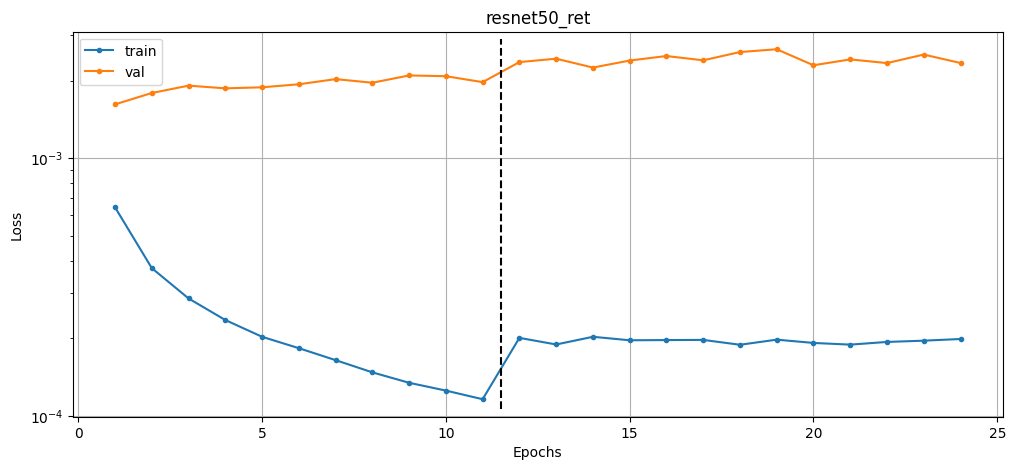

In [10]:
plt.figure(figsize=(12, 5))

plt.plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, label="train", marker=".")
plt.plot(range(1, len(mean_val_loss_list) + 1), mean_val_loss_list, label="val", marker=".")
plt.yscale("log")

plt.axvline(stage_1_epochs + 0.5, ymin=0.02, ymax=0.98, color="black", linestyle="--")

plt.title("{:s}".format(training_name_str))
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.grid()
plt.legend()

plt.show()

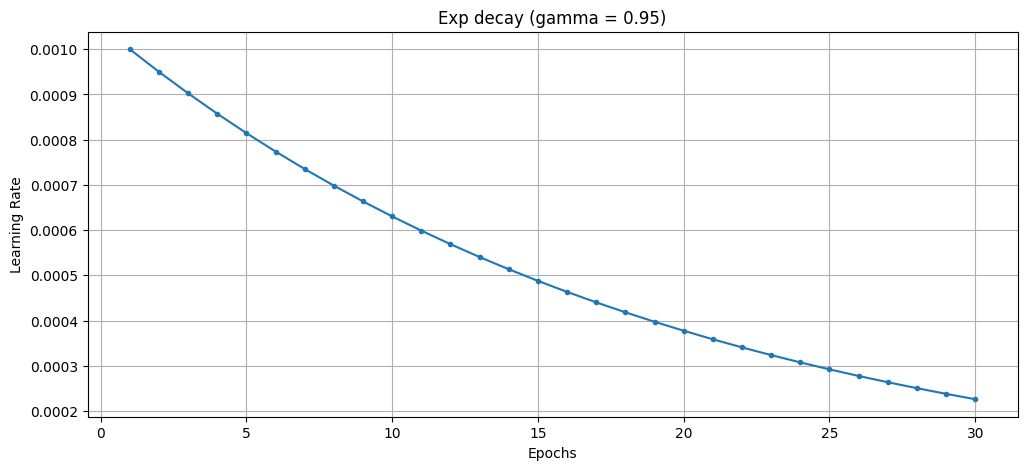

In [11]:
x = np.arange(1, 30 + 1)
y = 1e-3 * (0.95 ** (x - 1))

plt.figure(figsize=(12, 5))

plt.plot(x, y, marker=".")
#plt.yscale("log")

plt.title("Exp decay (gamma = 0.95)")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")

plt.grid()

plt.show()

In [12]:
utils.time.sprint_fancy_time_diff(sum(train_epoch_time_list[stage_1_epochs:]) + sum(val_epoch_time_list[stage_1_epochs:]))

'1:56:55.360'

In [13]:
utils.time.sprint_fancy_time_diff((sum(train_epoch_time_list[stage_1_epochs:]) + sum(val_epoch_time_list[stage_1_epochs:])) / stage_1_epochs)

'0:10:37.760'

In [14]:
utils.time.sprint_fancy_time_diff(sum(train_epoch_time_list[:stage_1_epochs]) + sum(val_epoch_time_list[:stage_1_epochs]))

'0:57:28.190'

In [15]:
utils.time.sprint_fancy_time_diff((sum(train_epoch_time_list[:stage_1_epochs]) + sum(val_epoch_time_list[:stage_1_epochs])) / stage_1_epochs)

'0:05:13.471'

In [16]:
utils.time.sprint_fancy_time_diff(sum(train_epoch_time_list) + sum(val_epoch_time_list))

'2:54:23.551'